# LAB 5. CONSTRAINED OPTIMIZATION: EQUALITY AND INEQUALITY CONSTRAINTS 

In this lab we are going to explore constrained optimization with equality and inequality constraints. This kind of problem appears, for example, when training Support Vector Machines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from QPGC import QPGenericConstraints

In [2]:
help(QPGenericConstraints)

Help on function QPGenericConstraints in module QPGC:

QPGenericConstraints(G, g, A, C, b, d)
    Convex optimization problem with equality and inequality constraints:
     
               min f(x)=1/2 x^T G X + g^T x     s.t.   A^T x = b i C^T x >= d
    
    Call it with:
    
    x = QPGenericConstrains(G, g, A, C, b, d)
    
    Notation:
    
    n = number of variables
    p = number of equality constants
    m = number of inequality constants
     
    Dimensions:   G -> n x n
                  g -> n x 1
                  A -> n x p
                  C -> n x m
                  b -> p x 1  
                  d -> m x 1



In [3]:
def generate_sample(m1, s1, m2, s2, n_samples, row_format=False):  # n_samples = m
    n_samples_class = n_samples // 2
    
    X_positive = np.random.multivariate_normal(m1, s1, n_samples_class)
    X_negative = np.random.multivariate_normal(m2, s2, n_samples_class)
    
    if row_format:
        X = np.hstack([X_positive.T, X_negative.T])
    else:
        X = np.vstack([X_positive, X_negative])
    
    y = np.r_[np.ones(n_samples_class), -np.ones(n_samples_class)]
    
    return X, y

In [4]:
def plot_sample(X, y, w=None, b=None, row_format=False):
    cdict = {1: 'red', -1: 'blue'}
    
    for c in np.unique(y):
        idx = np.where(y == c)

        x_coords = X[0, idx] if row_format else X[idx, 0]
        y_coords = X[1, idx] if row_format else X[idx, 1]

        plt.scatter(x_coords, y_coords, c=cdict[c], label=int(c))

    if w is not None and b is not None:
        # Compute min and max values for x-axis
        x_axis_vals = X[0, :] if row_format else X[:, 0]
        min_x = np.min(x_axis_vals)
        max_x = np.max(x_axis_vals)
        
        x_values = np.arange(min_x, max_x, 0.1)
        line = x_values * w[0] + b

        plt.plot(x_values, -line / w[1], 'k')
        plt.plot(x_values, (-line + 1) / w[1], 'k--')
        plt.plot(x_values, (-line - 1) / w[1], 'k--')

    plt.legend()
    plt.show()

In [5]:
def create_dual_formulation(X, y, n_samples, K=1):
    Y = np.diagflat(y)
    identity_mat = np.eye(n_samples)
    ones = np.ones(n_samples)
    
    G = np.dot(Y, np.dot(X.T, np.dot(X, Y)))
    g = -ones
    A = y.reshape(-1, 1)
    C = np.hstack([identity_mat, -identity_mat])
    b = np.zeros(1)
    d = np.r_[np.zeros(n_samples), -K * ones]
    
    return G, g, A, C, b, d


def svm_dual_space(X, y, n_samples, K=1, plot_results=True):
    # Create the data for the formulation in the dual space
    G, g, A, C, b, d = create_dual_formulation(X, y, n_samples, K=K)
    
    # Solve the problem and get the \alpha values
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    
    # Get the hyperplane and the bias
    w = np.dot(alpha * y, X.T)
    
    idx = np.where(alpha > 1e-6)[0]    
    b = np.mean(y[idx] - np.dot(w, X[:, idx]))
    
    if plot_results:
        plot_sample(X, y, w, b, row_format=True)
    
    return w, b

In [6]:
m1 = [0.,0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2sep = [3., 6.]
s2sep = [[1, 0], [0, 1]]
m2nsep = [1., 2.]
s2nsep = s2sep

## Simple case

First, we are going to test how solving the problem in the dual space works with a very simple case in which we have two separable classes with two samples each one. We want to see if we can get a hyperplane that separates the points of both classes and has maximal marigin. So, let's generate the data and solve the problem via the dual formulation.

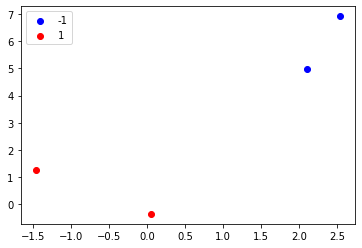

In [7]:
n_samples = 4
K = 1

X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples, row_format=True)
plot_sample(X, y, row_format=True)

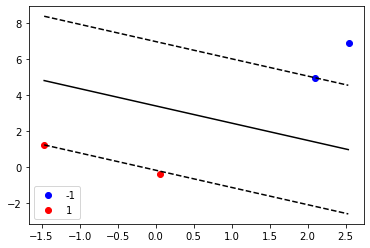

w: [-0.26831233 -0.27997831]	b: 0.9578358869522279


In [8]:
w, b = svm_dual_space(X, y, n_samples)
print(f'w: {w}\tb: {b}')

As we can see, we have obtained a hyperplane with maximal margin. There are three points that have been considered **support vectors**: the two points from the class $1$ and the one closest to the margin of the class $1$. Therefore, the classification lines at levels $-1$ and $+1$ go through them. There ara no points that fall inside the margin. Thus, we can see that this method is perfectly capable of solving this problem.

## A separable case with more data

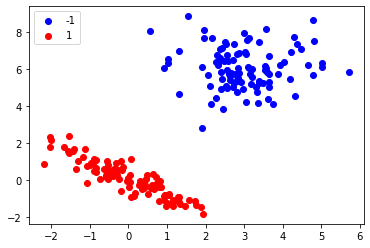

In [9]:
n_samples = 200
X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples, row_format=True)
plot_sample(X, y, row_format=True)

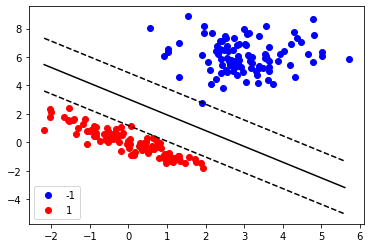

w: [-0.59658305 -0.53784142]	b: 1.6351691254967509


In [10]:
w, b = svm_dual_space(X, y, n_samples)
print(f'w: {w}\tb: {b}')

## Experimenting with different values of $K$

Let us now test different values of $K$ and see how this affects the result. We are going to repeat each experiment 3 times to see if the results are consistent for the same value of $K$.

In [11]:
def test_k_values(X, y, n_samples, K_list):
    for K in K_list:
        print(f'\n\n---------- Results for K={K} ----------\n\n')
        for _ in range(3):
            try:
                w, b = svm_dual_space(X, y, n_samples, K=K)
                print(f'w: {w}\tb: {b}')
            except np.linalg.LinAlgError as e:
                print('Error: ', e)



---------- Results for K=1 ----------




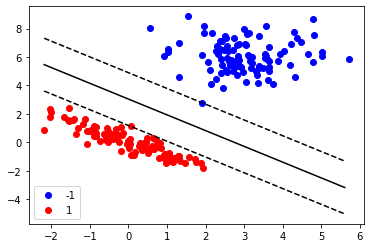

w: [-0.59658305 -0.53784142]	b: 1.6351691253213743


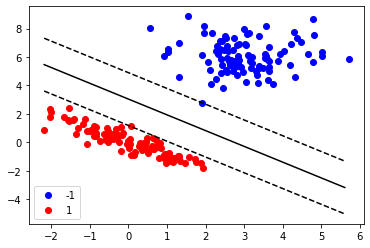

w: [-0.59658305 -0.53784142]	b: 1.6351691253213736


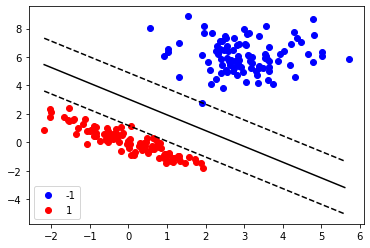

w: [-0.59658305 -0.53784142]	b: 1.6351691253213736


---------- Results for K=10 ----------




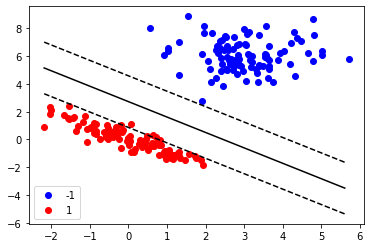

w: [-0.59653837 -0.53791344]	b: 1.4661178859947173


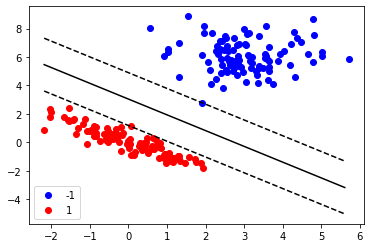

w: [-0.59658081 -0.53784502]	b: 1.6351739721293952


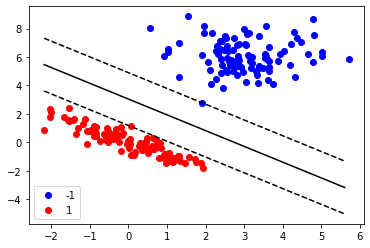

w: [-0.59658081 -0.53784502]	b: 1.6351739721293939


---------- Results for K=100 ----------




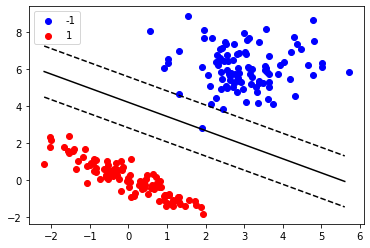

w: [-0.55197959 -0.72252359]	b: 3.0368504832948684


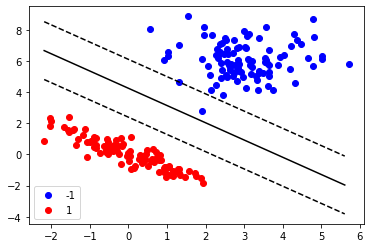

w: [-0.59593977 -0.53881138]	b: 2.2892717004485776


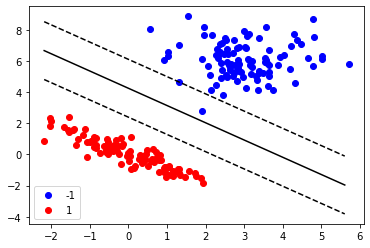

w: [-0.59593977 -0.53881138]	b: 2.289271700448698


---------- Results for K=1000 ----------




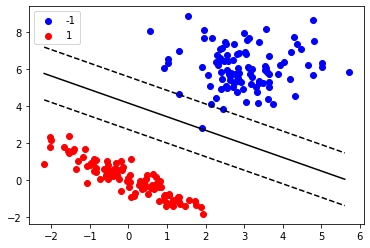

w: [-0.51410926 -0.6993546 ]	b: 2.90923291266224


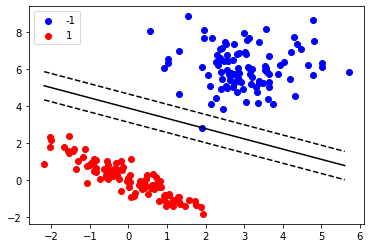

w: [-0.72468971 -1.30578288]	b: 5.0793064607292235


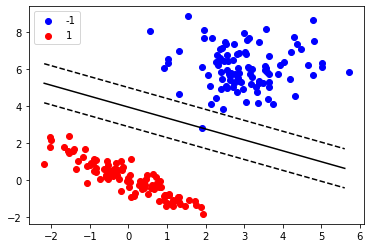

w: [-0.55793716 -0.94284319]	b: 3.7195001313107254


---------- Results for K=1000000.0 ----------




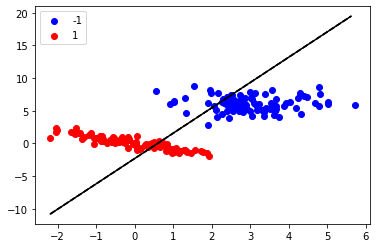

w: [ 1.77141142e+08 -4.56795522e+07]	b: -104814775.43209434


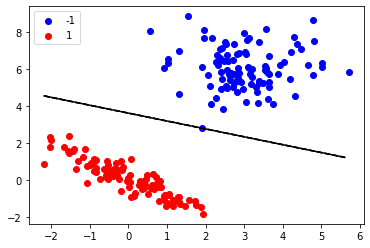

w: [-354.8642555  -830.27882985]	b: 3004.5046842324614


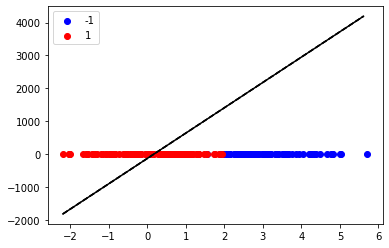

w: [ 1.42222240e+18 -1.84819524e+15]	b: -2.367150049709275e+17


---------- Results for K=100000000.0 ----------




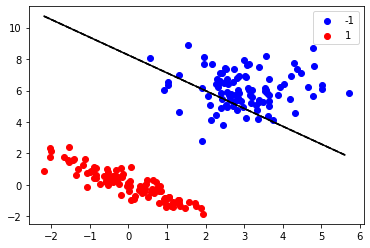

w: [6.94490931e+14 6.14339211e+14]	b: -5069698592604402.0


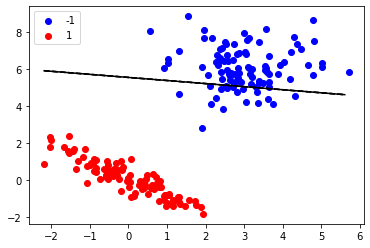

w: [4.06907314e+14 2.44335994e+15]	b: -1.3572336971210282e+16


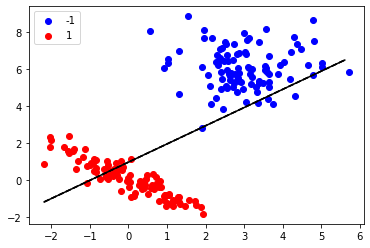

w: [-2.84459022e+17  2.88384224e+17]	b: -2.772061877757107e+17


---------- Results for K=10000000000.0 ----------




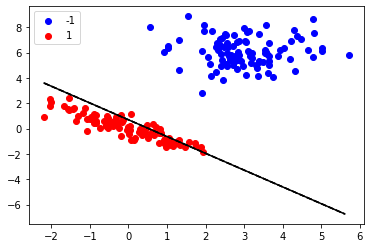

w: [-1.25234177e+17 -9.45799403e+16]	b: 6.603734803394199e+16


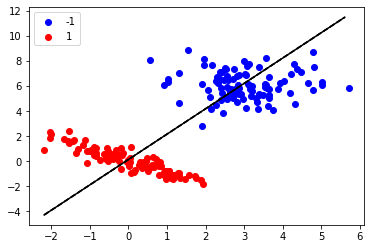

w: [13658.05212181 -6758.93439917]	b: 880.3247946869767


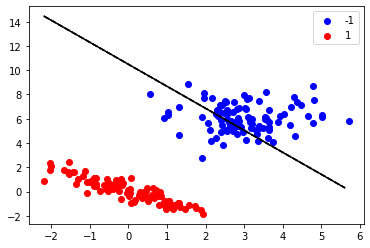

w: [2.38297579e+17 1.31473376e+17]	b: -1.3782619069846996e+18


---------- Results for K=1000000000000.0 ----------




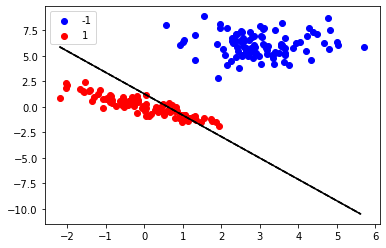

w: [8.56154652e+17 4.08533775e+17]	b: -5.2219721654826e+17


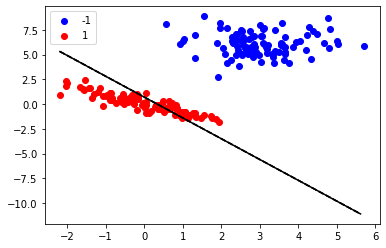

w: [3.35015840e+17 1.59384179e+17]	b: -1.135849135970326e+17


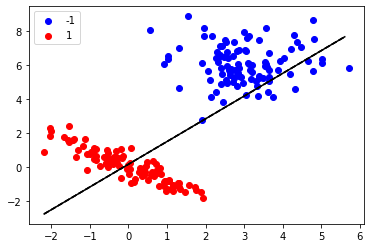

w: [-29892.27189297  22376.76198065]	b: -3748.0515234450017


In [12]:
K_list = [1, 10, 100, 1000, 1e6, 1e8, 1e10, 1e12]

test_k_values(X, y, n_samples, K_list)

Comment on the results here. There might be some problem with $K$.

## Non-separable case

After seeing how this method to obtain the SVM works with separable data, let's address a more real case scenario in which the data is non-separable.

First, we are going to generate the data and make a quick test on this method performs.

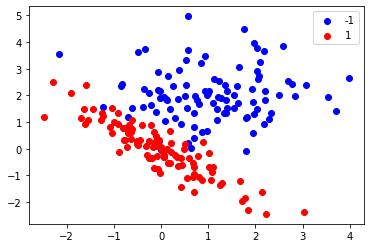

In [13]:
# Generate non-separable dataset
n_samples = 200
X, y = generate_sample(m1, s1, m2nsep, s2nsep, n_samples, row_format=True)
plot_sample(X, y, row_format=True)

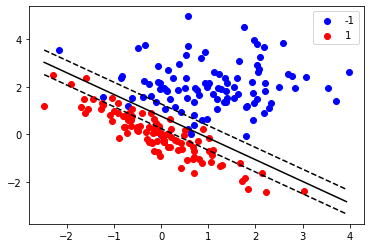

w: [-1.77524433 -1.93683874]	b: 1.4779508187166666


In [14]:
w, b = svm_dual_space(X, y, n_samples)
print(f'w: {w}\tb: {b}')

Here we shall comment the obtained results.



---------- Results for K=1 ----------




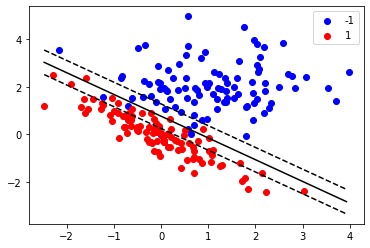

w: [-1.77524433 -1.93683874]	b: 1.4779508187166697


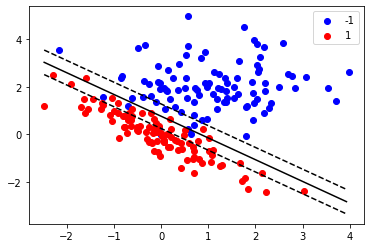

w: [-1.77524433 -1.93683874]	b: 1.4779508187166677


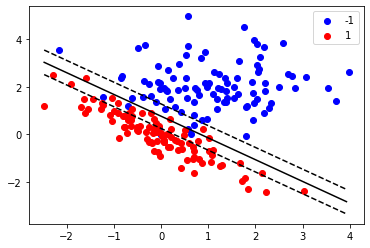

w: [-1.77524433 -1.93683874]	b: 1.4779508187166668


---------- Results for K=10 ----------




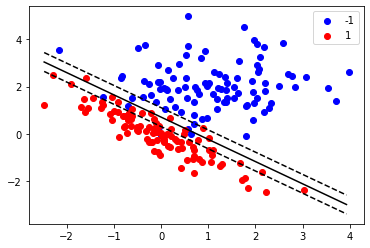

w: [-2.36206278 -2.51263689]	b: 1.7912290908943873


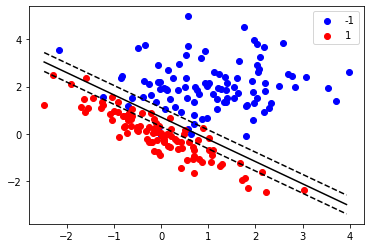

w: [-2.36206278 -2.51263689]	b: 1.7912290908943878


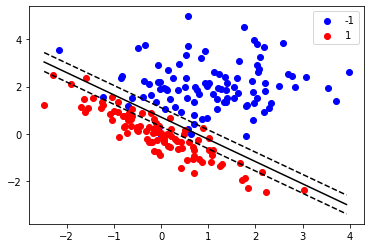

w: [-2.36206278 -2.51263689]	b: 1.7912290908943773


---------- Results for K=100 ----------




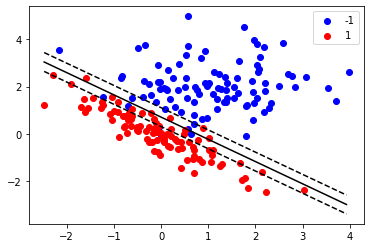

w: [-2.36206278 -2.51263689]	b: 1.7912290908941557


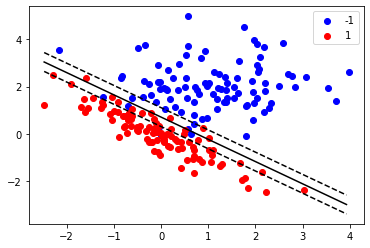

w: [-2.36206278 -2.51263689]	b: 1.7912290908941573


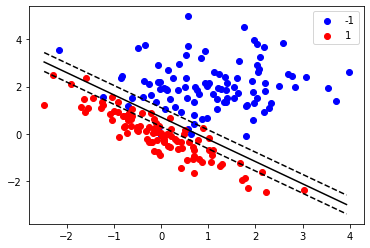

w: [-2.36206278 -2.51263689]	b: 1.7912290908942363


---------- Results for K=1000 ----------




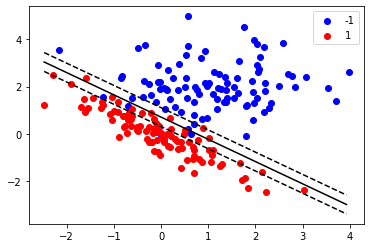

w: [-2.36206278 -2.51263689]	b: 1.7912290908946296


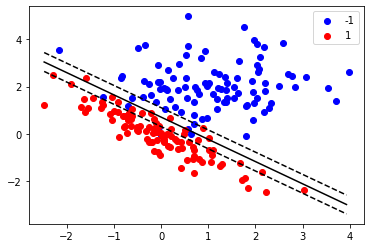

w: [-2.36206278 -2.51263689]	b: 1.7912290908946484


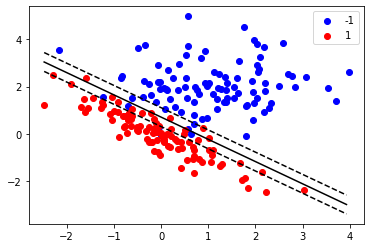

w: [-2.36206278 -2.51263689]	b: 1.791229090894637


---------- Results for K=1000000.0 ----------




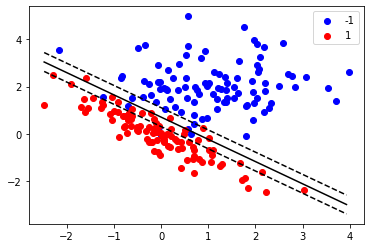

w: [-2.36206278 -2.51263689]	b: 1.7912290900189651


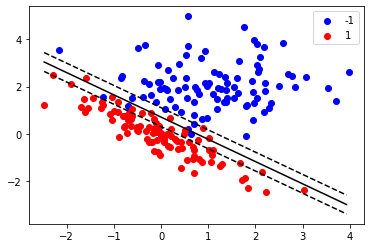

w: [-2.36206278 -2.51263689]	b: 1.7912290913124918


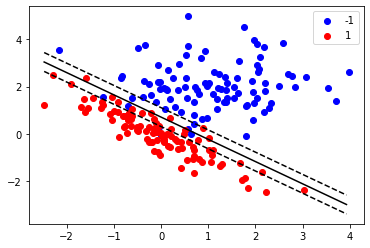

w: [-2.36206278 -2.51263689]	b: 1.791229091296948


---------- Results for K=100000000.0 ----------




/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


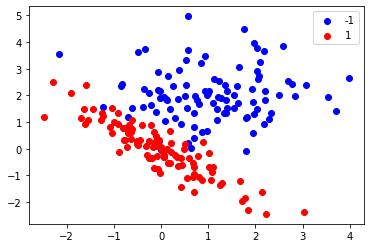

w: [nan nan]	b: nan


/home/oslab/QPGC.py:99: RuntimeWarning: invalid value encountered in multiply
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


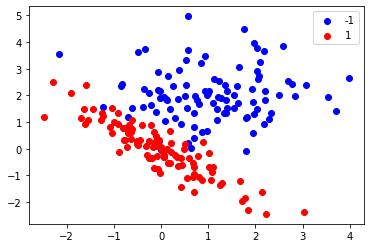

w: [nan nan]	b: nan


/home/oslab/QPGC.py:99: RuntimeWarning: invalid value encountered in multiply
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


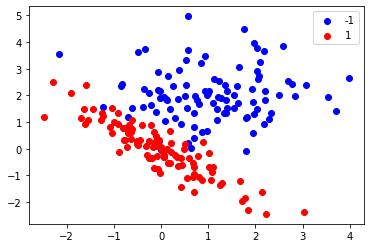

w: [nan nan]	b: nan


---------- Results for K=10000000000.0 ----------




/home/oslab/QPGC.py:99: RuntimeWarning: invalid value encountered in multiply
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


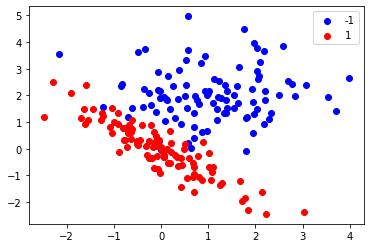

w: [nan nan]	b: nan


/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


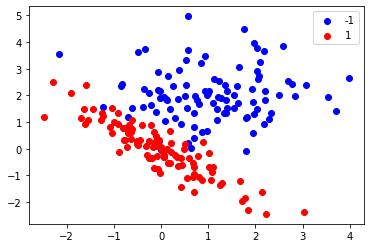

w: [nan nan]	b: nan


/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


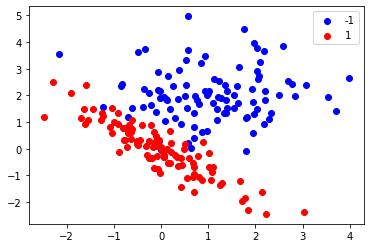

w: [nan nan]	b: nan


---------- Results for K=1000000000000.0 ----------




/home/oslab/QPGC.py:99: RuntimeWarning: invalid value encountered in multiply
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


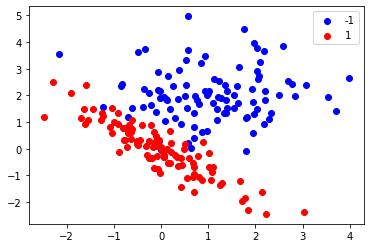

w: [nan nan]	b: nan


/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


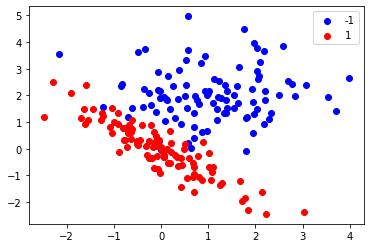

w: [nan nan]	b: nan


/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/volokin/PythonEnvironments/data-science-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


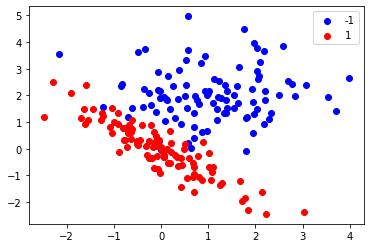

w: [nan nan]	b: nan


In [15]:
K_list = [1, 10, 100, 1000, 1e6, 1e8, 1e10, 1e12]

test_k_values(X, y, n_samples, K_list)

# LAB 6: STOCHASTIC GRADIENT DESCENT FOR SVM

In [16]:
def f(X, y, lamb, w, b):
    return 0.5 * lamb * np.dot(w, w) + np.sum(np.maximum(0, 1 - y * (np.dot(X, w) + b)))


def stochastic_gradient_descent(X, y, n_epochs=500, mu_0=100, mu_increment=0.1, lamb=1e-4, batch_size=10):
    n_samples = X.shape[0]
    mu = mu_0
    
    # Declare parameters
    w = np.array([1., 1.])
    b = 0
    
    log_f_values = [np.log(f(X, y, lamb, w, b))]
    
    for j in range(n_epochs):
        shuffle_idx = np.random.permutation(np.arange(n_samples))
        X_shuffled, y_shuffled = X[shuffle_idx], y[shuffle_idx]
                
        for i in range(0, n_samples, batch_size):
            gamma = 1 / mu

            X_mini_batch, y_mini_batch = X_shuffled[i:i+batch_size], y_shuffled[i:i+batch_size]
            
            mask = y_mini_batch * (np.dot(X_mini_batch, w) + b) <= 1
            
            # y needs to be transformed so that the element wise multiplication
            # with the elements of the batch can be performed            
            w = w - gamma * (lamb * w + np.sum(-y_mini_batch[mask, np.newaxis] * X_mini_batch[mask], axis=0))
            b = b - gamma * np.sum(-y_mini_batch[mask])
            
            mu += mu_increment
        
        log_f_values.append(np.log(f(X, y, lamb, w, b)))

    
    return w, b, np.array(log_f_values)

In [17]:
m1 = [0.,0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2sep = [3., 6.]
s2sep = [[1, 0], [0, 1]]
m2nsep = [1., 2.]
s2nsep = s2sep

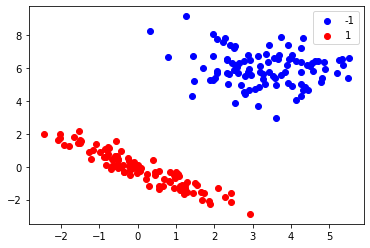

In [18]:
n_samples = 200

X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples)
plot_sample(X, y)

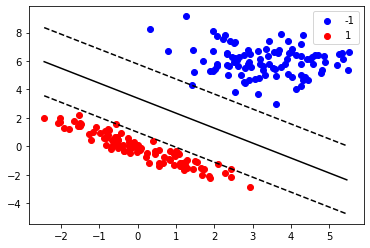

In [19]:
w, b, log_f_values_1 = stochastic_gradient_descent(X, y, batch_size=1, n_epochs=2000)
plot_sample(X, y, w, b)

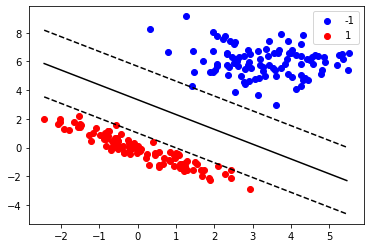

In [20]:
w, b, log_f_values_20 = stochastic_gradient_descent(X, y, batch_size=20, n_epochs=2000)
plot_sample(X, y, w, b)

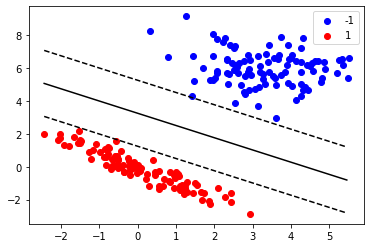

In [21]:
w, b, log_f_values_200 = stochastic_gradient_descent(X, y, batch_size=200, n_epochs=2000, lamb=1, mu_increment=0.01)
plot_sample(X, y, w, b)

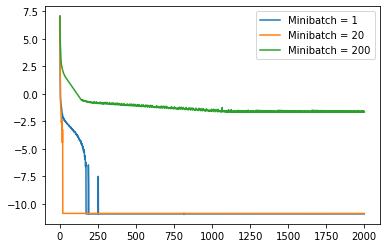

In [22]:
plt.plot(np.arange(len(log_f_values_1)), log_f_values_1, label='Minibatch = 1')
plt.plot(np.arange(len(log_f_values_20)), log_f_values_20, label='Minibatch = 20')
plt.plot(np.arange(len(log_f_values_200)), log_f_values_200, label='Minibatch = 200')

plt.legend()
plt.show()

## Non-separable case

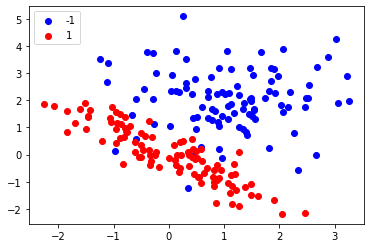

In [23]:
n_samples = 200

X, y = generate_sample(m1, s1, m2nsep, s2nsep, n_samples)
plot_sample(X, y)

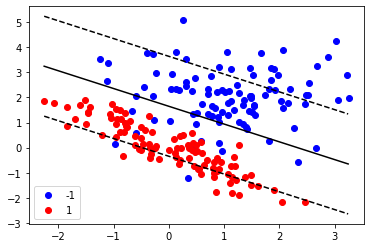

In [26]:
w, b, log_f_values_1 = stochastic_gradient_descent(X, y, batch_size=1, n_epochs=2000, lamb=1, mu_increment=0.01)
plot_sample(X, y, w, b)

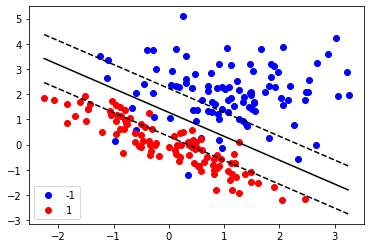

In [25]:
w, b, log_f_values_20 = stochastic_gradient_descent(X, y, batch_size=20, n_epochs=2000, lamb=1, mu_increment=0.01)
plot_sample(X, y, w, b)

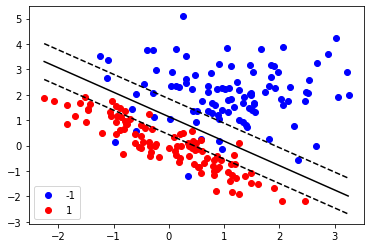

In [27]:
w, b, log_f_values_200 = stochastic_gradient_descent(X, y, batch_size=200, n_epochs=2000, lamb=1, mu_increment=0.01)
plot_sample(X, y, w, b)

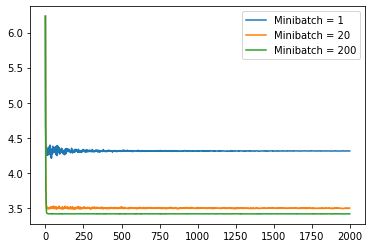

In [28]:
plt.plot(np.arange(len(log_f_values_1)), log_f_values_1, label='Minibatch = 1')
plt.plot(np.arange(len(log_f_values_20)), log_f_values_20, label='Minibatch = 20')
plt.plot(np.arange(len(log_f_values_200)), log_f_values_200, label='Minibatch = 200')

plt.legend()
plt.show()